In [99]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import ugradio
import astropy
import time

%matplotlib notebook

In [70]:
C = astropy.constants.c.value

In [26]:
def radec2vec(ra, dec):
    phi = np.pi/2 - dec
    x = np.sin(phi) * np.cos(ra)
    y = np.sin(phi) * np.sin(ra)
    z = np.cos(phi)
    vec = np.array([x, y, z])
    return vec

# unit tests
np.testing.assert_almost_equal(radec2vec(0, 0), np.array([1, 0, 0]))
np.testing.assert_almost_equal(radec2vec(np.pi, 0), np.array([-1, 0, 0]))
np.testing.assert_almost_equal(radec2vec(np.pi/2, 0), np.array([0, 1, 0]))
np.testing.assert_almost_equal(radec2vec(0, np.pi/2), np.array([0, 0, 1]))
np.testing.assert_almost_equal(radec2vec(0, -np.pi/2), np.array([0, 0, -1]))
#s_hat = radec2vec(ra, dec)

In [76]:
def rot_mat_eq2ha(lst):
    '''Do earth rotation to current orientation specified by LST'''
    ones = np.ones_like(lst)
    rot_mat = np.array([
        [ np.cos(lst), np.sin(lst), 0*ones],
        [-np.sin(lst), np.cos(lst), 0*ones],
        [      0*ones,      0*ones, 1*ones],
    ])
    return rot_mat

# unit tests
np.testing.assert_almost_equal(rot_mat_eq2ha(0), np.array([[1, 0, 0],[0,1,0],[0,0,1]]))
np.testing.assert_almost_equal(rot_mat_eq2ha(np.pi/2), np.array([[0, 1, 0],[-1,0,0],[0,0,1]]))
ans = np.array([[[1, 0, 0],[0,1,0],[0,0,1]], [[0, 1, 0],[-1,0,0],[0,0,1]]])
ans = np.transpose(ans, axes=[1, 2, 0])
np.testing.assert_almost_equal(rot_mat_eq2ha(np.array([0, np.pi/2])), ans)

In [60]:
def rot_mat_ha2top(lat):
    rot_mat = np.array([
        [           0, 1,           0],
        [-np.sin(lat), 0, np.cos(lat)],
        [ np.cos(lat), 0, np.sin(lat)],
    ])
    return rot_mat
    
# unit tests
np.testing.assert_almost_equal(rot_mat_ha2top(0), np.array([[0, 1, 0],[0, 0,1],[1,0,0]]))
np.testing.assert_almost_equal(rot_mat_ha2top(np.pi/2), np.array([[ 0, 1, 0],[-1,0,0],[0,0,1]]))

In [112]:
jd0 = 2460382.1
#jd0 = ugradio.timing.julian_date()
jds = np.linspace(jd0, jd0+0.5, 10000)
lsts = ugradio.timing.lst(jds)
lat_deg = ugradio.nch.lat

ra_deg, dec_deg = ugradio.coord.sunpos(jd)
ra = np.deg2rad(ra_deg)
dec = np.deg2rad(dec_deg)
lat = np.deg2rad(lat_deg)

bl = np.array([20., 0.5, 0]) # meters

s_equ = radec2vec(ra, dec)
Req2ha = rot_mat_eq2ha(lsts)
Rha2top = rot_mat_ha2top(lat)
Rfull = np.einsum('ij,jyt->iyt', Rha2top, Req2ha)

s_top = np.einsum('iyt,y->it', Rfull, s_equ)
bl_proj = np.einsum('i,it', bl, s_top)

snap_freqs = np.linspace(0, 250e6, 1024, endpoint=False)
LO1 = 8.75e9 # Hz
LO2 = 1.55e9 # Hz
freqs = snap_freqs + LO1 + LO2
freq = freqs[600]  # look at one channel
lam = C / freq # wavelength in meters

# fringe calculation
w = bl_proj / lam
fringe = np.exp(1j * 2 * np.pi * w)

# bessel calculation
rsun = np.deg2rad(0.25)
uv = np.sqrt(np.dot(bl, bl) - bl_proj**2) / lam
x = 2 * np.pi * uv * rsun
bessel = scipy.special.j1(x) / x

visibility = bessel * fringe

<IPython.core.display.Javascript object>


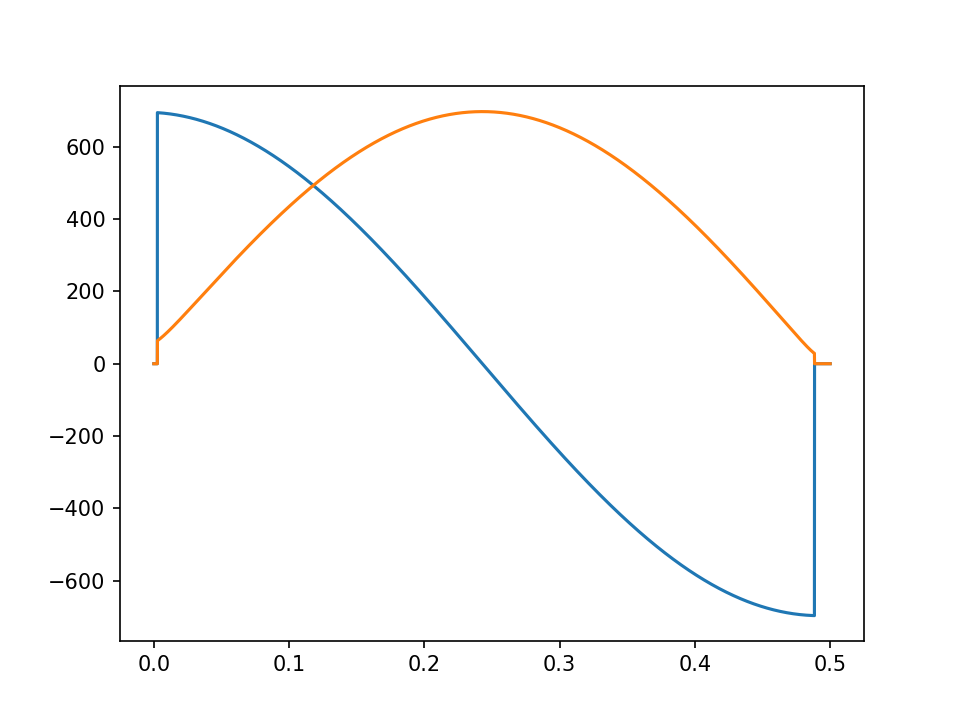

In [113]:
plt.figure()
plt.plot(jds - jd0, np.where(s_top[2] > 0, w, 0))
plt.plot(jds - jd0, np.where(s_top[2] > 0, uv, 0))

<IPython.core.display.Javascript object>


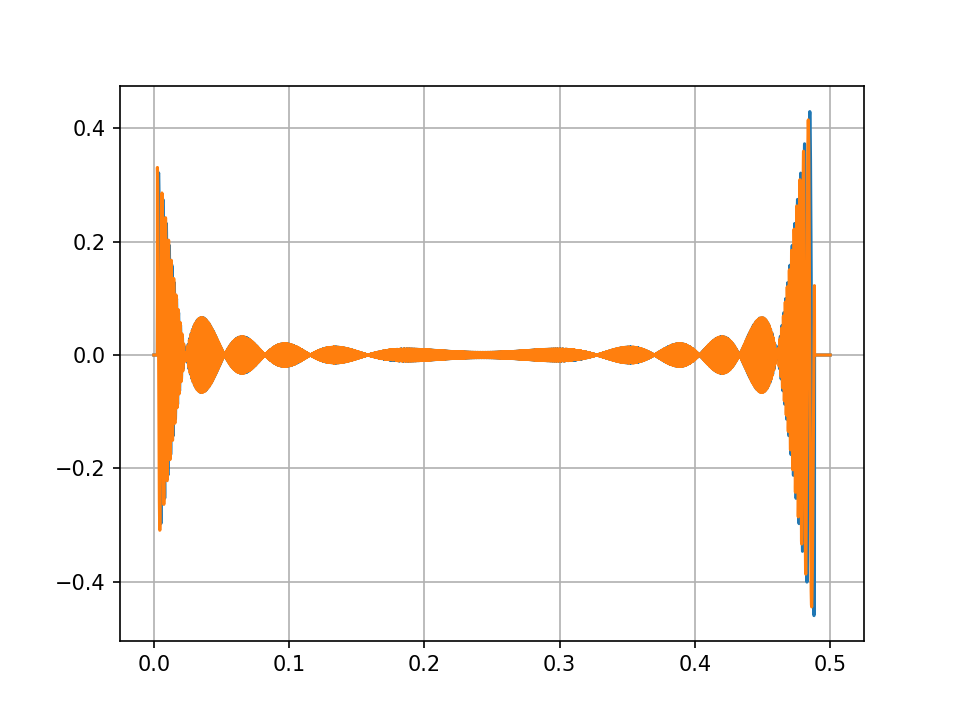

In [114]:
plt.figure()
#plt.plot(jds-jd0, np.where(s_top[2] > 0, bl_proj, 0))
plt.plot(jds-jd0, np.where(s_top[2] > 0, visibility.real, 0))
plt.plot(jds-jd0, np.where(s_top[2] > 0, visibility.imag, 0))
plt.grid()

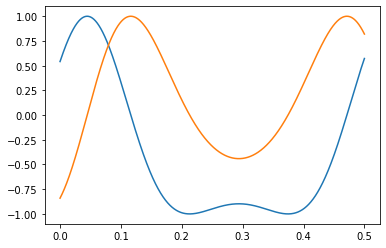

In [84]:
plt.figure()
plt.plot(jds-jd0, fringe.real)
plt.plot(jds-jd0, fringe.imag)

In [52]:
lst

0.16783615105103022

In [115]:
inttime = 2.5

In [137]:
fringe_freq, tind, data_f = scipy.signal.stft(visibility, window='boxcar',
                                              fs=1/inttime, nperseg=512, axis=0, return_onesided=False)

<IPython.core.display.Javascript object>


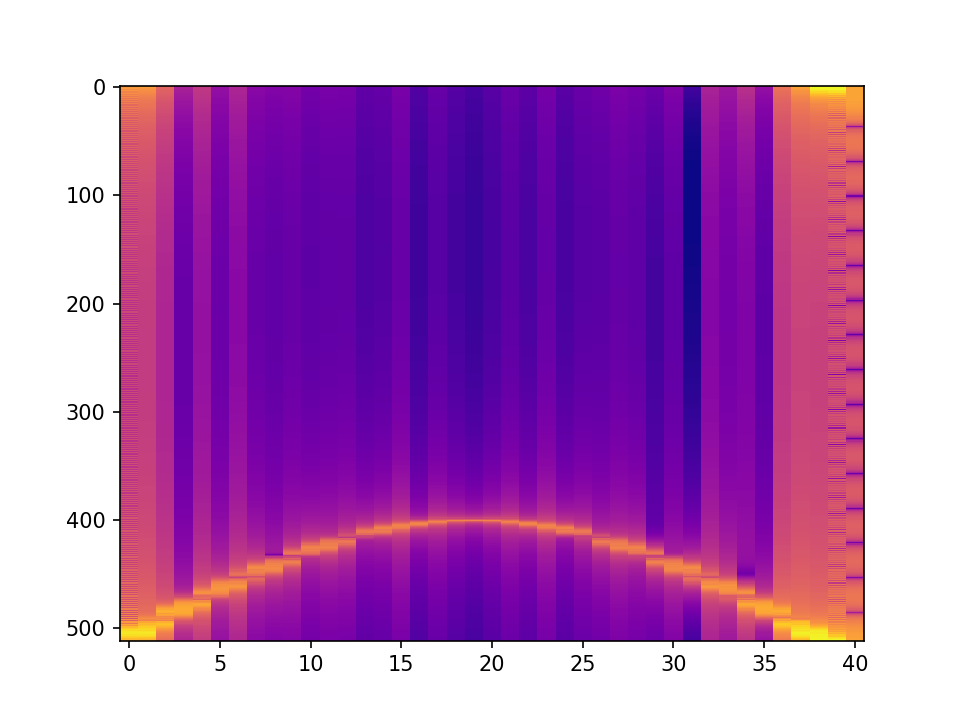

In [139]:
plt.figure()
plt.imshow(np.log10(np.abs(data_f)), aspect='auto', interpolation='nearest', cmap='plasma')